https://stackoverflow.com/questions/45545110/how-do-you-parallelize-apply-on-pandas-dataframes-making-use-of-all-cores-on-o/45545111

In [1]:
!pip install dask distributed --upgrade

  Using cached https://files.pythonhosted.org/packages/b1/91/1014cdf012dd706ffecbca2de1e3b28517305ba7f49cfdd4fb6b6de5df07/dask-1.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/37/560b694bc2fe80c04bb64e3959e29afda4f7ed715726e357b05f01cfe07e/distributed-1.27.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/13/f3/cf85f7c3a2dbd1a515d51e1f1676d971abe41bba6f4ab5443240d9a78e5b/sortedcontainers-2.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bd/45/a2e6f95a850cd407d785f2f8624b02e72baf6ab910aea4bdcac7e18b4871/zict-0.1.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/92/7e/ae9e91c1bb8d846efafd1f353476e3fd7309778b582d2fb4cea4cc15b9a2/msgpack-0.6.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fa/37/45185cb5abbc30d7257104c434fe0b07e5a195a6847506c074527aa599ec/Click-7.0-py2.py3-none-any.whl
  Found existing installation: dask 0.19.4

In [2]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:36245 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.10 GB


In [3]:
import time
import pickle
import matplotlib.pyplot as plt
import pandas
print('pandas',pandas.__version__)
import numpy
print('numpy',numpy.__version__)
import dask.dataframe as dd
from dask.multiprocessing import get

pandas 0.23.4
numpy 1.13.3


In [4]:
df = pandas.DataFrame(
    numpy.random.randint(0,1000,size=(1000, 4)), 
    columns=list('ABCD')
    )
print(df.shape)
df.head()

(1000, 4)


,A,B,C,D
0,668,666,636,7
1,749,885,65,555
2,961,115,57,19
3,646,356,215,548
4,645,330,554,854


In [5]:
ddata = dd.from_pandas(df, npartitions=4)

In [6]:
def double_col_a(row):
    row_as_dict=dict(row)
    return row_as_dict['A']*2

options for scheduler are 'single-threaded','threads','processes'

The threaded scheduler executes computations with a local `multiprocessing.pool.ThreadPool`.

See https://docs.dask.org/en/latest/scheduling.html

In [7]:
# https://stackoverflow.com/questions/45545110/how-do-you-parallelize-apply-on-pandas-dataframes-making-use-of-all-cores-on-o/45545111
start_time = time.time()
res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
print(time.time() - start_time)

0.1999213695526123


In [8]:
with open('multiprocessing_data.pkl','rb') as f: 
    serial_reslts, pool_reslts, lambda_reslts = pickle.load(f)

In [9]:
serial_reslts

{100: 0.01564290523529053,
 1000: 0.13357844352722167,
 10000: 1.9118867635726928,
 100000: 12.924072241783142}

In [10]:
pool_reslts

{100: 0.1539085626602173,
 1000: 0.15258731842041015,
 10000: 0.8222435235977172,
 100000: 7.081635594367981}

In [11]:
number_of_tests=10
list_of_row_size=list(pool_reslts.keys())

In [12]:
dask_threads_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
        test_reslts.append(time.time() - start_time)
    dask_threads_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 0.36089611053466797 for 100
elapsed time: 1.8978700637817383 for 1000
elapsed time: 16.043235301971436 for 10000
elapsed time: 149.09759497642517 for 100000


In [13]:
dask_processes_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='processes')
        test_reslts.append(time.time() - start_time)
    dask_processes_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 2.211142063140869 for 100
elapsed time: 5.115724086761475 for 1000
elapsed time: 14.595972061157227 for 10000
elapsed time: 91.55149459838867 for 100000


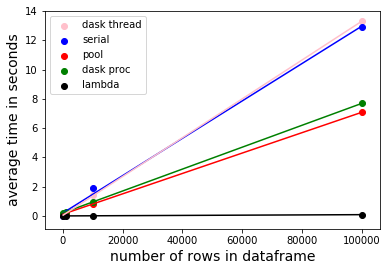

In [14]:
serial_x = list(serial_reslts.keys()) # list_of_row_size
serial_y = list(serial_reslts.values())

pool_x = list(pool_reslts.keys()) # list_of_row_size
pool_y = list(pool_reslts.values())

lambda_x = list(lambda_reslts.keys()) # list_of_row_size
lambda_y = list(lambda_reslts.values())

dask_processes_x = list(dask_processes_reslts.keys()) # list_of_row_size
dask_processes_y = list(dask_processes_reslts.values())

dask_threads_x = list(dask_threads_reslts.keys()) # list_of_row_size
dask_threads_y = list(dask_threads_reslts.values())


_=plt.scatter(dask_threads_x,dask_threads_y,color='pink',label='dask thread')
_=plt.scatter(serial_x,serial_y,color='blue',label='serial')
_=plt.scatter(pool_x,pool_y,color='red',label='pool')
_=plt.scatter(dask_processes_x,dask_processes_y,color='green',label='dask proc')
_=plt.scatter(lambda_x,lambda_y,color='black',label='lambda')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x)),color='blue') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x)),color='red') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(lambda_x), numpy.poly1d(numpy.polyfit(lambda_x, lambda_y, 1))(numpy.unique(lambda_x)),color='black') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_processes_x), numpy.poly1d(numpy.polyfit(dask_processes_x, dask_processes_y, 1))(numpy.unique(dask_processes_x)),color='green') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_threads_x), numpy.poly1d(numpy.polyfit(dask_threads_x, dask_threads_y, 1))(numpy.unique(dask_threads_x)),color='pink') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

ax = plt.gca()
_=ax.legend()
#ax.grid(True)

Dask vs multiprocessing:
https://github.com/dask/dask/issues/1783

There are additional libraries built on top of Dask,<BR>

https://github.com/jmcarpenter2/swifter
https://github.com/jmcarpenter2/swifter/blob/master/examples/swifter_apply_examples.ipynb
https://github.com/jmcarpenter2/swifter/blob/master/examples/swiftapply_speedcomparison.ipynb

# Dask dashboard
    
https://docs.dask.org/en/latest/diagnostics-distributed.html

In [15]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

/opt/conda/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


see http://localhost:8787/status

# Profiling

https://docs.dask.org/en/latest/diagnostics-local.html

In [16]:
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

In [17]:
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,CacheProfiler() as cprof:
    res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='processes')

In [18]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

bokeh.models.layouts.Column(
    id='e823138c-fdbe-4bc0-8d50-d1a5c9d61ca8',
    children=[bokeh.models.tools.ToolbarBox(
         id='686f0a7a-68e3-42d4-9609-9e3b1a47ee01',
         css_classes=[],
         disabled=False,
         height=None,
         js_event_callbacks={},
         js_property_callbacks={},
         name=None,
         sizing_mode='fixed',
         subscribed_events=[],
         tags=[],
         toolbar=bokeh.models.tools.ProxyToolbar(
             id='c482f71b-55a6-4c01-b29f-72136a5981cc',
             js_event_callbacks={},
             js_property_callbacks={},
             logo='normal',
             name=None,
             subscribed_events=[],
             tags=[],
             tools=[bokeh.models.tools.HoverTool(
                  id='b4c42182-16ac-496c-9205-111655996f46',
                  anchor='center',
                  attachment='horizontal',
                  callback=None,
                  formatters={},
                  js_event_callbacks={},
                  js_property_callbacks={},
                  line_policy='nearest',
                  mode='mouse',
                  name=None,
                  names=[],
                  point_policy='follow_mouse',
                  renderers='auto',
                  show_arrow=True,
                  subscribed_events=[],
                  tags=[],
                  toggleable=True,
                  tooltips='\n    <div>\n        <span style="font-size: 14px; font-weight: bold;">Key:</span>&nbsp;\n        <span style="font-size: 10px; font-family: Monaco, monospace;">@key</span>\n    </div>\n    <div>\n        <span style="font-size: 14px; font-weight: bold;">Task:</span>&nbsp;\n        <span style="font-size: 10px; font-family: Monaco, monospace;">@function</span>\n    </div>\n    '),
              bokeh.models.tools.SaveTool(
                  id='18ae37a0-96a7-4be8-9d51-ca08bcd8ffb6',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.ResetTool(
                  id='4551bfd7-0ef9-488b-95e8-0bdd40e8bfca',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.WheelZoomTool(
                  id='b1517233-de45-4415-8ef2-548dc04dfac1',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  maintain_focus=True,
                  name=None,
                  speed=0.0016666666666666668,
                  subscribed_events=[],
                  tags=[],
                  zoom_on_axis=True),
              bokeh.models.tools.PanTool(
                  id='48d77f14-3970-499e-8945-4a9f199756d5',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.SaveTool(
                  id='f333af1b-d094-4437-b678-41c50b760903',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.ResetTool(
                  id='7e115bbc-baa7-4902-833c-ef0567b4cdd0',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  name=None,
                  subscribed_events=[],
                  tags=[]),
              bokeh.models.tools.WheelZoomTool(
                  id='d63c32d1-dc0b-49b2-961f-84c3a784270a',
                  dimensions='width',
                  js_event_callbacks={},
                  js_property_callbacks={},
                  maintain_focus=True,
     

In [19]:
prof.visualize()

bokeh.plotting.figure.Figure(
    id='dae1b6b4-76bf-4588-b81f-a9ff9947a376',
    above=[],
    aspect_scale=1,
    background_fill_alpha={'value': 1.0},
    background_fill_color={'value': '#ffffff'},
    below=[bokeh.models.axes.LinearAxis(
         id='7c19bf24-ac0e-4f17-b812-053c749e2a26',
         axis_label='Time (s)',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_label_text_color={'value': '#444444'},
         axis_label_text_font='helvetica',
         axis_label_text_font_size={'value': '10pt'},
         axis_label_text_font_style='italic',
         axis_label_text_line_height=1.2,
         axis_line_alpha={'value': 1.0},
         axis_line_cap='butt',
         axis_line_color={'value': None},
         axis_line_dash=[],
         axis_line_dash_offset=0,
         axis_line_join='bevel',
         axis_line_width={'value': 1},
         bounds='auto',
         fixed_location=None,
         formatter=bokeh.models.formatters.BasicTickFormatter(
             id='97e3cbbe-63f8-4b5f-bf7f-0a86a2fbbb32',
             js_event_callbacks={},
             js_property_callbacks={},
             name=None,
             power_limit_high=5,
             power_limit_low=-3,
             precision='auto',
             subscribed_events=[],
             tags=[],
             use_scientific=True),
         js_event_callbacks={},
         js_property_callbacks={},
         level='overlay',
         major_label_orientation='horizontal',
         major_label_overrides={},
         major_label_standoff=5,
         major_label_text_align='center',
         major_label_text_alpha={'value': 1.0},
         major_label_text_baseline='alphabetic',
         major_label_text_color={'value': '#444444'},
         major_label_text_font='helvetica',
         major_label_text_font_size={'value': '8pt'},
         major_label_text_font_style='normal',
         major_label_text_line_height=1.2,
         major_tick_in=2,
         major_tick_line_alpha={'value': 1.0},
         major_tick_line_cap='butt',
         major_tick_line_color={'value': None},
         major_tick_line_dash=[],
         major_tick_line_dash_offset=0,
         major_tick_line_join='bevel',
         major_tick_line_width={'value': 1},
         major_tick_out=6,
         minor_tick_in=0,
         minor_tick_line_alpha={'value': 1.0},
         minor_tick_line_cap='butt',
         minor_tick_line_color={'value': 'black'},
         minor_tick_line_dash=[],
         minor_tick_line_dash_offset=0,
         minor_tick_line_join='bevel',
         minor_tick_line_width={'value': 1},
         minor_tick_out=4,
         name=None,
         plot=bokeh.plotting.figure.Figure(id='dae1b6b4-76bf-4588-b81f-a9ff9947a376', ...),
         subscribed_events=[],
         tags=[],
         ticker=bokeh.models.tickers.BasicTicker(
             id='c18287af-33f3-496d-926c-6ed133f1f527',
             base=10.0,
             desired_num_ticks=6,
             js_event_callbacks={},
             js_property_callbacks={},
             mantissas=[1, 2, 5],
             max_interval=None,
             min_interval=0.0,
             name=None,
             num_minor_ticks=5,
             subscribed_events=[],
             tags=[]),
         visible=True,
         x_range_name='default',
         y_range_name='default')],
    border_fill_alpha={'value': 1.0},
    border_fill_color={'value': '#ffffff'},
    css_classes=[],
    disabled=False,
    extra_x_ranges={},
    extra_y_ranges={},
    h_symmetry=True,
    height=None,
    hidpi=True,
    js_event_callbacks={},
    js_property_callbacks={},
    left=[bokeh.models.axes.CategoricalAxis(
         id='21288d58-b2a7-48da-ada5-7544bff0b2b5',
         axis_label='Worker ID',
         axis_label_standoff=5,
         axis_label_text_align='left',
         axis_label_text_alpha={'value': 1.0},
         axis_label_text_baseline='bottom',
         axis_

In [20]:
!pip install graphviz

In [21]:
res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).visualize()